# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [57]:
import time
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder



from sklearn.model_selection import train_test_split
# from sklearn.impute import KNNImputer, SimpleImputer


data = pd.read_csv('autos.csv')

display(
    data.head(),
    data.info(),
    data.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


# 1.Предобработка данных 

In [14]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Описание данных 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

### Целевой признак

**Price** - цена (евро)

Имеем пропуски в след.столбцах
- VehicleType (тип автомобильного кузова)
- Gearbox (тип коробки передач)
- Model (модель автомобиля)
- FuelType (тип топлива)
- NotRepaired (была машина в ремонте или нет)

    

Признаки, которые не повлияют на предсказание цены (DateCrawled, RegistrationMonth,  DateCreated, NumberOfPictures, PostalCode и LastSeen) - удалим.

In [15]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
                                                                                                       "There are " + str(
            mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

In [16]:
missing_zero_values_table(data)

Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
NotRepaired,0,71154,20.1,71154,20.1,object
VehicleType,0,37490,10.6,37490,10.6,object
FuelType,0,32895,9.3,32895,9.3,object
Gearbox,0,19833,5.6,19833,5.6,object
Model,0,19705,5.6,19705,5.6,object


Доля пропусков в столбцах довольна большая и составляет примерно от 5 до 20%.

In [17]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Т.к имеем довольно много пропусков в категориальных признаках, то попробуем  ввести новую категорию 

In [18]:

for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna('unknown', inplace=True)
        
        print(col)
        print(data[col].value_counts(normalize=True)*100)
        print('\n')

VehicleType
sedan          25.808409
small          22.527648
wagon          18.389306
unknown        10.579368
bus             8.120067
convertible     5.701119
coupe           4.561065
suv             3.385172
other           0.927846
Name: VehicleType, dtype: float64


Gearbox
manual     75.698213
auto       18.705079
unknown     5.596709
Name: Gearbox, dtype: float64


Model
golf                  8.249029
other                 6.891404
3er                   5.576391
unknown               5.560588
polo                  3.687117
                        ...   
i3                    0.002258
serie_3               0.001129
rangerover            0.001129
range_rover_evoque    0.000564
serie_1               0.000564
Name: Model, Length: 251, dtype: float64


FuelType
petrol      61.052744
gasoline    27.857967
unknown      9.282697
lpg          1.498438
cng          0.159438
hybrid       0.065751
other        0.057567
electric     0.025397
Name: FuelType, dtype: float64


NotRepaired
no  

In [19]:
# Замена типа данных на категориальные

cols_cat = data.select_dtypes(include='object').columns
for col in cols_cat:
    data[col] = data[col].astype('category')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             354369 non-null  int64   
 1   VehicleType       354369 non-null  category
 2   RegistrationYear  354369 non-null  int64   
 3   Gearbox           354369 non-null  category
 4   Power             354369 non-null  int64   
 5   Model             354369 non-null  category
 6   Kilometer         354369 non-null  int64   
 7   FuelType          354369 non-null  category
 8   Brand             354369 non-null  category
 9   NotRepaired       354369 non-null  category
dtypes: category(6), int64(4)
memory usage: 13.2 MB


In [21]:

def distr_plot(col, col_name):
    
    '''
    Функция как аргумент принимает признак и его название. 
    Функция возвращает информацию о распределении признака.  
    '''
    
    sns.displot(x = col, legend=True, kde=True, height=5.7, aspect=1.5, bins=100)
    plt.title('Распределение значений признака ' + str(col_name).title(), fontsize=16)

    plt.figure(figsize=(9.7, 6))
    sns.boxplot(y=col)

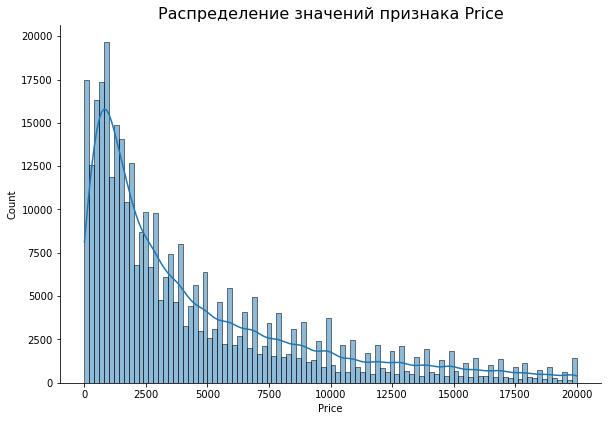

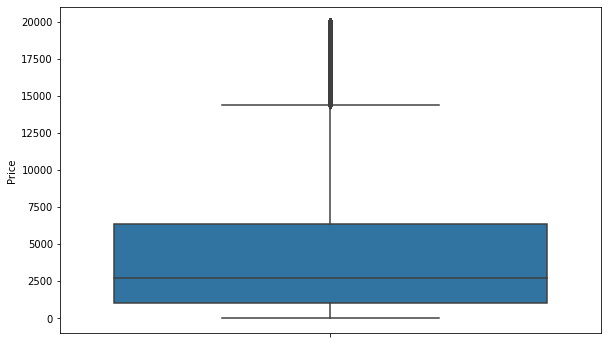

In [22]:
distr_plot(data['Price'], 'Price')

Узнаем процентную долю выбрососв в данных

In [23]:
print('Процент выбросов:', len(data.query('Price < 200 or Price >14600')) / len(data) *100)


Процент выбросов: 9.908880291447614


Уберём аномальные объекты в данных

In [26]:
clean_data = data.query('Price >= 200 or Price <=15000')
clean_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


(-10.0, 1000.0)

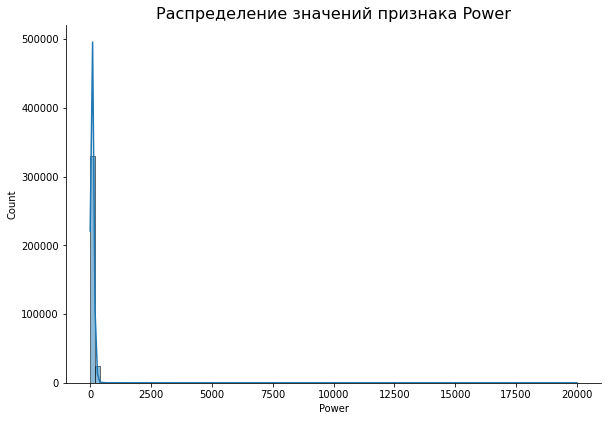

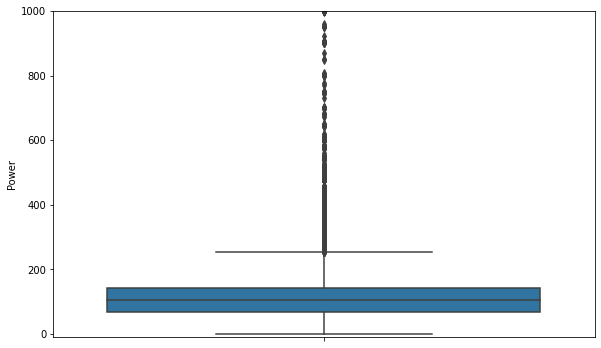

In [27]:
distr_plot(data['Power'], 'Power')
plt.ylim(-10, 1000)

следует отметить, что имеются нулевые значения в колонке Power. Возможно, что владелец при заполнении анкеты не стал указывать данные. Заменим их на медианное значение

In [28]:
clean_data['Power'] = clean_data['Power'].replace(0, np.nan)
median = clean_data.groupby(['Brand', 'Model', 'FuelType'])['Power'].transform('median')
clean_data['Power'] = clean_data['Power'].fillna(median)

In [29]:
print('К-во пропусков в колонке Power:', clean_data['Power'].isnull().sum())

К-во пропусков в колонке Power: 100


In [30]:
clean_data.dropna(inplace=True)
clean_data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

Посмотрим на пробег автомобилей

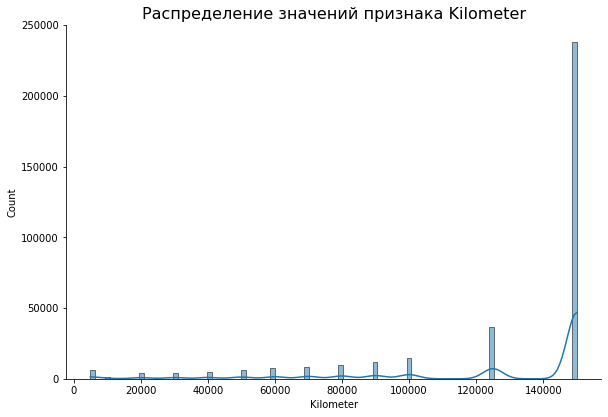

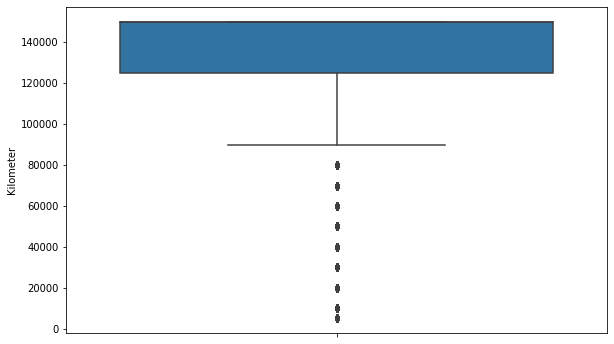

In [31]:
distr_plot(data['Kilometer'], 'Kilometer')

пробег у всех разный и это естественный процесс, никаких манипуляций с этим признакам производить не будем

Если обратиться к историческим данным, то старше автомобилей 1768го года мы не сможем наблюдать на дорогах. Исапавим этот момент


In [32]:
clean_data = clean_data.query('RegistrationYear > 1768')
clean_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,90.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,82.0,colt,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,85.0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [33]:
#Обработаем дубликаты
clean_data.drop_duplicates(inplace=True)

/home/al/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [35]:
clean_data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,90.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,82.0,colt,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,85.0,unknown,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


# 2.Обучение моделей

Сравним работу следующих моделей
- LinearRegression
- CatBoostRegressor
- LGBMRegressor

C помощью техники One Hot Encoding - преобразуем категориальные признаки в числовые. Аргумент drop_first поможет избавиться от мультиколлинеарности в данных

In [39]:
df_ohe = pd.get_dummies(clean_data, drop_first=True)
df_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,90.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,2005,82.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
354365,2200,2005,85.0,20000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
354366,1199,2000,101.0,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# Разобъём данные train/valid/test

target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)



In [41]:

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)

In [42]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

In [43]:
samples = {'Размер обучающей выборки' : features_train, 
          'Размер валидационной выборки': features_valid, 
          'Размер тестовой выборки': features_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (184663, 311)
Размер валидационной выборки: (61554, 311)
Размер тестовой выборки: (61555, 311)


In [45]:
# Масштабирование признаков


to_scale = ['RegistrationYear', 'Power', 'Kilometer']

scaler = MinMaxScaler()
scaler.fit(features_train[to_scale])

MinMaxScaler()

In [47]:
features_train[to_scale] = scaler.transform(features_train[to_scale])
features_valid[to_scale] = scaler.transform(features_valid[to_scale])
features_test[to_scale] = scaler.transform(features_test[to_scale])

/home/al/.local/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Реализуем функцию потерь, которая будет относиться к нашим моделям

In [55]:
def rmse(target, pred):
    mse = mean_squared_error(target, pred)
    rmse = mse**0.5
    return rmse

### Linear Regression

In [60]:
lr = LinearRegression()

In [65]:
start = time.time() 
lr.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time (FIT): ', end_time_fit)

End time (FIT):  6.659727096557617


In [66]:
start = time.time() 
predictions_lr = lr.predict(features_valid)
end_time_predict = time.time() - start

end_time_predict

0.1357564926147461

In [67]:
print('RMSE на валидационной выборке:', rmse(target_valid, predictions_lr))


RMSE на валидационной выборке: 3238.0788117968596


In [68]:
results = []
results.append({'Модель': 'LinearRegression', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lr)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,6.659727,0.135756,3238.078812


###  LGBMRegressor

In [70]:
parameters = {'boosting_type': 'gbdt', 
              'max_depth': 11, 
              'n_estimators': 120, 
              'random_state': 123}

In [71]:

model_lgbm = LGBMRegressor(**parameters)

In [76]:

start = time.time() 
model_lgbm.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time: ', end_time_fit)

End time:  2.517472267150879


In [73]:

start = time.time() 
predictions_lgbm = model_lgbm.predict(features_valid, verbose=2)
end_time_predict = time.time() - start
print('End time: ', end_time_predict)

End time:  0.4412362575531006


In [74]:
print('RMSE на валидационной выборке:', rmse(target_valid, predictions_lgbm))


RMSE на валидационной выборке: 1869.8048080270985


In [75]:

results.append({'Модель': 'LGBMRegressor', 
                'Параметры': parameters, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lgbm)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,6.659727,0.135756,3238.078812
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_...",2.684276,0.441236,1869.804808


Видно, что качество модели LGBMRegressor выше чем у линейной регрессии. Интересен также тот факт, что обучаестя и предсказывает lgbm быстрее.

In [88]:
for est in range(30, 150, 30):
    for depth in range(5, 15):
        model_lgbm = LGBMRegressor(random_state=123, n_estimators=est, max_depth=depth, boosting_type='gbdt')
        start = time.time() 
        model_lgbm.fit(features_train, target_train)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_lgbm = model_lgbm.predict(features_valid, verbose=1)
        end_time_predict = time.time() - start

        RMSE = rmse(target_valid, predictions_lgbm)
    
        results.append({'Модель': 'LGBMRegressor', 
                'Параметры': parameters, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lgbm)})

### CatBoostRegressor

In [77]:
for iteration in range(10, 101, 20):
    
    for depth in range(5, 11, 2):
    
        model_cbr = CatBoostRegressor(random_state=123, iterations=iteration, loss_function='RMSE', depth=depth)
    
        start = time.time() 
        model_cbr.fit(features_train, target_train)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid, verbose=1)
        end_time_predict = time.time() - start

        RMSE = rmse(target_valid, predictions_cbr)
    
        results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'random_state':123, 
                                      'iterations': iteration, 
                                      'loss_function': 'RMSE', 
                                      'depth': depth}, 
                        'Время обучения': end_time_fit, 
                        'Скорость предсказания': end_time_predict, 
                        'RMSE': RMSE})


Learning rate set to 0.5
0:	learn: 3376.6121322	total: 113ms	remaining: 1.02s
1:	learn: 2825.0049823	total: 139ms	remaining: 556ms
2:	learn: 2600.3835700	total: 159ms	remaining: 372ms
3:	learn: 2448.9243376	total: 180ms	remaining: 270ms
4:	learn: 2372.1601111	total: 200ms	remaining: 200ms
5:	learn: 2318.4485092	total: 220ms	remaining: 146ms
6:	learn: 2270.7699565	total: 239ms	remaining: 102ms
7:	learn: 2243.4739723	total: 258ms	remaining: 64.5ms
8:	learn: 2214.1707654	total: 277ms	remaining: 30.7ms
9:	learn: 2186.5069607	total: 297ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3257.6319147	total: 27.5ms	remaining: 248ms
1:	learn: 2705.8545561	total: 59.2ms	remaining: 237ms
2:	learn: 2430.5268315	total: 93.8ms	remaining: 219ms
3:	learn: 2310.1462088	total: 123ms	remaining: 185ms
4:	learn: 2237.5530160	total: 152ms	remaining: 152ms
5:	learn: 2192.4636347	total: 180ms	remaining: 120ms
6:	learn: 2146.1339463	total: 207ms	remaining: 88.8ms
7:	learn: 2119.6492330	total: 235ms	remaining

In [84]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [89]:
pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,6.659727,0.135756,3238.078812
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 120, 'random_state': 123}",2.684276,0.441236,1869.804808
2,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 5}",1.828460,0.068097,2199.124647
3,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 7}",1.432595,0.022013,2082.373490
4,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 9}",1.449368,0.027192,2023.723258
5,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 5}",1.768026,0.024297,2018.800479
6,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 7}",1.823217,0.024871,1947.460040
7,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 9}",2.183814,0.028266,1907.789662
8,CatBoostRegressor,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 5}",2.164075,0.026341,1952.765339
9,CatBoostRegressor,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 7}",2.289679,0.030245,1897.947087


# 3.Сравнение моделей и вывод

- Лучший показатель RMSE наблюдается у модели CatBoost (1830)
- Скорость предсказания также забирает CatBoost (iterations=10, depth=7), также у неё самая низкая скорость обучения, но качество оставляет желать лучшего


Ну и напоследок сравним результаты наших обученных моделей со случайным предиктором.


In [90]:

dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_train)
predictions_r_dummy = dummy_regr.predict(features_test)
print('RMSE dummy:', rmse(target_test, predictions_r_dummy))

RMSE dummy: 4559.7252054924


Результаты наших моделей превосходят Дамми модель, значит они имеют место быть, но также им необходим серьёзный тюнинг и более тательный подбор параметров.